In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [2]:
cbsa_data = pd.read_csv('/Users/jericho/Documents/csi/family-geog/data/clean/cbsa/cbsa_summary.csv')
cbsa_data['GTCBSA'] = cbsa_data['GTCBSA'].astype(str).apply(lambda x: x.zfill(5))
cbsa_data.head(3)

def bin_equal(array,bins):
    amin,amax = min(array),max(array)
    step = (amax-amin)/bins
    bins = [(i-amin)//step for i in array]
    mbin = max(bins)
    bin_partitions = [amin+step*i for i in range(int(mbin)+2)]
    return bins, bin_partitions

cbsa_data = pd.read_csv('/Users/jericho/Documents/csi/family-geog/data/clean/cbsa/cbsa_summary.csv')
cbsa_data['GTCBSA'] = cbsa_data['GTCBSA'].astype(str).apply(lambda x: x.zfill(5))
cbsa_data.head(3)

cbsa_df = copy.deepcopy(cbsa_data[['GTCBSA', 'POP', 'LOG_POP', 'AVG_FAMILY_TIME', 'AVG_NHFAMILY_IX', 
            'AVG_FAMILY_IX','AVG_NHFAMILY_NONWORK_TIME', 'AVG_FRIEND_NONWORK_TIME', 
            'AVG_CCC_NONWORK_TIME', 'AVG_NHSOCIAL_TIME', 'AVG_NHFAMILY_SOCIAL_TIME_RATIO']])

bins,partitions = bin_equal(cbsa_df['LOG_POP'],6)
cbsa_df['bin'] = bins
cbsa_df['sum'] = cbsa_df['AVG_NHFAMILY_NONWORK_TIME'] + cbsa_df['AVG_FRIEND_NONWORK_TIME'] + cbsa_df['AVG_CCC_NONWORK_TIME']
cbsa_df = cbsa_df[['GTCBSA','bin', 'POP', 'LOG_POP']]
cbsa_df.head(3)

GTCBSA  bin     POP  LOG_POP
0  10180  0.0  170669     5.23
1  10420  2.0  703845     5.85
2  10580  2.0  880736     5.94

In [3]:
data_loc = '/Users/jericho/Documents/csi/csi-research/Data/atus/'

act_df = pd.DataFrame()
resp_df = pd.DataFrame()
who_df = pd.DataFrame()
ec_df = pd.DataFrame()
cps_df = pd.DataFrame()

for i in range(2016,2020):
    act_file = f'atusact_{i}/atusact_{i}.dat'
    resp_file = f'atusresp_{i}/atusresp_{i}.dat'
    who_file = f'atuswho_{i}/atuswho_{i}.dat'
    ec_file  = f'atusrostec_{i}/atusrostec_{i}.dat'
    cps_file = f'atuscps_{i}/atuscps_{i}.dat'

    temp_act_df = pd.read_csv(data_loc+act_file)
    temp_resp_df = pd.read_csv(data_loc+resp_file)
    temp_who_df = pd.read_csv(data_loc+who_file)
    temp_ec_df = pd.read_csv(data_loc+ec_file)
    temp_cps_df = pd.read_csv(data_loc+cps_file)

    act_df = pd.concat([act_df, temp_act_df])
    resp_df = pd.concat([resp_df, temp_resp_df])
    who_df = pd.concat([who_df, temp_who_df])
    ec_df = pd.concat([ec_df, temp_ec_df])
    cps_df = pd.concat([cps_df, temp_cps_df])

weights_df = pd.read_csv('/Users/jericho/Documents/csi/family-geog/data/clean/cbsa_adjusted_weights_6_iter.csv')

cps_df = cps_df[['TUCASEID','GTCBSA']]
cps_df['GTCBSA'] = cps_df['GTCBSA'].astype(str).apply(lambda x: x.zfill(5))
cps_df = cps_df[cps_df['GTCBSA']!='00000']
cps_df = cps_df.drop_duplicates()
cps_weights_df = cps_df.merge(weights_df, how='right',on='TUCASEID')
cps_weights_bins = cps_weights_df.merge(cbsa_df,how='left',on='GTCBSA')
cps_weights_bins = cps_weights_bins[~cps_weights_bins['GTCBSA'].isna()]

In [4]:
days = resp_df[['TUCASEID','TUDIARYDAY']]
days.to_csv('who_day.csv')

In [5]:
bin_weights = cps_weights_bins[['bin','NEW_WEIGHT']].groupby('bin').sum()
act_df_trunc = act_df #        [act_df['TUTIER1CODE']==4] # filter to Code 4      ################################
keep_cols = ['TUCASEID', 'TUACTIVITY_N','TEWHERE', 'TUACTDUR24','TUTIER1CODE','TUTIER2CODE','TUTIER3CODE','TRCODE']
act_df_trunc = act_df_trunc[keep_cols]

In [6]:
act_df_labeled = copy.deepcopy(act_df_trunc)
who_df_labeled = copy.deepcopy(who_df)

act_df_labeled['combined_label'] = act_df_labeled['TUCASEID'].astype(str) + '_' + act_df_labeled['TUACTIVITY_N'].astype(str)
who_df_labeled['combined_label'] = who_df_labeled['TUCASEID'].astype(str) + '_' + who_df_labeled['TUACTIVITY_N'].astype(str)
act_who = act_df_labeled.merge(who_df_labeled,how='left',on='combined_label')

act_who = act_who[['TUCASEID_x', 'TUACTIVITY_N_x', 'TEWHERE', 'TUACTDUR24', 'TUTIER1CODE',
       'TUTIER2CODE', 'TUTIER3CODE', 'TRCODE', 'TRWHONA', 'TULINENO', 
       'TUWHO_CODE']]

act_who.columns = ['TUCASEID', 'TUACTIVITY_N', 'TEWHERE', 'TUACTDUR24', 'TUTIER1CODE',
       'TUTIER2CODE', 'TUTIER3CODE', 'TRCODE', 'TRWHONA', 'TULINENO', 
       'TUWHO_CODE']

act_who_where = act_who.merge(cps_weights_bins,on='TUCASEID',how='left')
act_who_where = act_who_where[~act_who_where['bin'].isna()]

In [7]:
act_who_where.shape

(784994, 16)

In [7]:
act_who_where.head()

TUCASEID  TUACTIVITY_N  TEWHERE  TUACTDUR24  TUTIER1CODE  \
0  20160101160045             1       -1         420            1   
1  20160101160045             2        1          20            2   
2  20160101160045             3        1          10           11   
3  20160101160045             3        1          10           11   
4  20160101160045             4        1          25            2   

   TUTIER2CODE  TUTIER3CODE  TRCODE  TRWHONA  TULINENO  TUWHO_CODE GTCBSA  \
0            1            1   10101        1        -1          -1  12060   
1            2            1   20201        0         1          18  12060   
2            1            1  110101        0         2          20  12060   
3            1            1  110101        0         3          22  12060   
4            2            3   20203        0         1          18  12060   

   NEW_WEIGHT  bin        POP  LOG_POP  
0     20976.0  4.0  5862424.0     6.77  
1     20976.0  4.0  5862424.0     6.77  
2     20976.0  4.0  5862424.0     6.77  
3     20976.0  4.0  5862424.0     6.77  
4     20976.0  4.0  5862424.0     6.77

In [8]:
# nhfam_accomp = [40,51,52,53]
# labels = ['Caring For & Helping NonHH Children', \
#     'Activities Related to Nonhh Children\'s Education', \
#     'Activities Related to Nonhh Children\'s Health', \
#     'Caring For Nonhousehold Adults', \
#     'Helping Nonhousehold Adults']

# fig,axes = plt.subplots(3,2,figsize=(8,8))

# for i in range(1,6):
#     # Accept only NH Family accompaniments
#     act_who_where_nh = copy.deepcopy(act_who_where[act_who_where['TUWHO_CODE'].isin(nhfam_accomp)])
#     act_who_where_nh = act_who_where_nh[act_who_where_nh['TUTIER2CODE']==i]

#     # # Accept all accompaniments
#     # act_who_where_nh = copy.deepcopy(act_who_where)#[act_who_where['TUWHO_CODE'].isin(nhfam_accomp)])
#     # act_who_where_nh = act_who_where_nh[act_who_where_nh['TUTIER2CODE']==i]

#     print(labels[i-1], len(act_who_where_nh))
#     bincount = act_who_where_nh[['TUCASEID','NEW_WEIGHT','bin']]
#     bincount = bincount.drop_duplicates()
#     binvals  = bincount.groupby('bin').sum()
#     binvals  = pd.concat([binvals, bin_weights], axis=1)
#     binvals.columns = ['TUCASEID','SUM_WEIGHT','BIN_WEIGHT']
#     binvals['ratio'] = binvals['SUM_WEIGHT'] / binvals['BIN_WEIGHT']
#     binvals

#     y = (i-1)//3
#     x = (i-1)%3

#     axes[x,y].scatter(binvals.index.tolist(),binvals.ratio.tolist())
#     axes[x,y].plot(binvals.index.tolist(),binvals.ratio.tolist())
#     axes[x,y].set_title(labels[i-1])

# plt.tight_layout()
# plt.show()
# #plt.yscale('log')
# #binvals

In [9]:
# nhfam_accomp = [40,51,52,53]
# labels = ['Caring For & Helping NonHH Children', \
#     'Activities Related to Nonhh Children\'s Education', \
#     'Activities Related to Nonhh Children\'s Health', \
#     'Caring For Nonhousehold Adults', \
#     'Helping Nonhousehold Adults']


# act_who_where_nh = copy.deepcopy(act_who_where[act_who_where['TUWHO_CODE'].isin(nhfam_accomp)])
# bincount = act_who_where_nh[['TUCASEID','NEW_WEIGHT','bin']]
# bincount = bincount.drop_duplicates()
# binvals  = bincount.groupby('bin').sum()
# binvals  = pd.concat([binvals, bin_weights], axis=1)
# binvals.columns = ['TUCASEID','SUM_WEIGHT','BIN_WEIGHT']
# binvals['ratio'] = binvals['SUM_WEIGHT'] / binvals['BIN_WEIGHT']
# binvals
# print(len(bincount))
# plt.scatter(binvals.index.tolist(),binvals.ratio.tolist())
# plt.plot(binvals.index.tolist(),binvals.ratio.tolist())
# plt.title('All Caring')
# plt.show()



In [9]:
# IN EC Roster File
hh_teelwho = [20,21,22,23,24,25,26,27] # teelwho is for providing elder care
nh_teelwho = [33,34,35,36,37,38,39,40,41,42,47,48,49]

# IN Who File
hhfam_accomp = [20,21,22,23,24,25,26,27] # TUWHO_CODE is for who was with you
nhfam_accomp = [40,51,52,53]
friend_accomp = [54]
coworker_accomp = [59,60,61]


In [23]:
all_fam = hhfam_accomp + nhfam_accomp + [-1] + [i for i in range(31)]
non_fam = copy.deepcopy(act_who_where)
non_fam['non_fam'] = non_fam['TUWHO_CODE'].apply(lambda x: 0 if x in all_fam else 1)
non_fam = non_fam[['TUCASEID','NEW_WEIGHT','GTCBSA','non_fam']].drop_duplicates()
non_fam['non_fam'] = non_fam['non_fam'] * non_fam['NEW_WEIGHT'] 
non_fam = non_fam.groupby('GTCBSA').sum()
non_fam['f_other'] = non_fam['non_fam'] / non_fam['NEW_WEIGHT']
non_fam = non_fam.reset_index()
non_fam = non_fam[['GTCBSA','f_other']]
non_fam.head()

non_fam.to_csv('/Users/jericho/Documents/csi/csi-research/Notebooks/cbsa_f_other.csv', index=False)

### Repeat above but with Duration

In [11]:
# bin_weights = cps_weights_bins[['bin','NEW_WEIGHT']].groupby('bin').sum()
# act_df_trunc = act_df[act_df['TUTIER1CODE']==4] # filter to Code 4 
# keep_cols = ['TUCASEID', 'TUACTIVITY_N','TEWHERE', 'TUACTDUR24','TUTIER1CODE','TUTIER2CODE','TUTIER3CODE','TRCODE']
# act_df_trunc = act_df_trunc[keep_cols]

# act_df_labeled = copy.deepcopy(act_df_trunc)
# who_df_labeled = copy.deepcopy(who_df)

# act_df_labeled['combined_label'] = act_df_labeled['TUCASEID'].astype(str) + '_' + act_df_labeled['TUACTIVITY_N'].astype(str)
# who_df_labeled['combined_label'] = who_df_labeled['TUCASEID'].astype(str) + '_' + who_df_labeled['TUACTIVITY_N'].astype(str)
# act_who = act_df_labeled.merge(who_df_labeled,how='left',on='combined_label')

# act_who = act_who[['TUCASEID_x', 'TUACTIVITY_N_x', 'TEWHERE', 'TUACTDUR24', 'TUTIER1CODE',
#        'TUTIER2CODE', 'TUTIER3CODE', 'TRCODE', 'TRWHONA', 'TULINENO', 
#        'TUWHO_CODE']]

# act_who.columns = ['TUCASEID', 'TUACTIVITY_N', 'TEWHERE', 'TUACTDUR24', 'TUTIER1CODE',
#        'TUTIER2CODE', 'TUTIER3CODE', 'TRCODE', 'TRWHONA', 'TULINENO', 
#        'TUWHO_CODE']

# act_who_where = act_who.merge(cps_weights_bins,on='TUCASEID',how='left')
# act_who_where = act_who_where[~act_who_where['bin'].isna()]


# nhfam_accomp = [40,51,52,53]
# labels = ['Caring For & Helping NonHH Children', \
#     'Activities Related to Nonhh Children\'s Education', \
#     'Activities Related to Nonhh Children\'s Health', \
#     'Caring For Nonhousehold Adults', \
#     'Helping Nonhousehold Adults']


In [12]:
# act_who_where_nh = copy.deepcopy(act_who_where[act_who_where['TUWHO_CODE'].isin(nhfam_accomp)])
# bin_dur = act_who_where_nh[['TUCASEID','TUACTDUR24', 'NEW_WEIGHT','bin']]

# bin_dur_vals = bin_dur.groupby('TUCASEID').mean()
# bin_dur_vals['weighted_dur'] = bin_dur_vals['TUACTDUR24'] * bin_dur_vals['NEW_WEIGHT']

# bin_agg_dur = bin_dur_vals.groupby('bin').sum()
# bin_agg_count = bin_dur_vals.groupby('bin').count()
# bin_agg_dur['Weighted_Dur_Avg'] = bin_agg_dur['weighted_dur'] / bin_agg_dur['NEW_WEIGHT']

# display(bin_dur_vals.head())
# display(bin_agg_dur)
# display(bin_agg_count)

# plt.plot(bin_agg_dur['Weighted_Dur_Avg'])
# plt.scatter([i for i in range(len(bin_agg_dur['Weighted_Dur_Avg']))],bin_agg_dur['Weighted_Dur_Avg'])
# plt.title("All Caring Weighted Duration")


In [13]:
# bin_weights = cps_weights_bins[['bin','NEW_WEIGHT']].groupby('bin').sum()
# #act_df_trunc = act_df[act_df['TUTIER1CODE']==4] # filter to Code 4 
# act_df_trunc = act_df
# keep_cols = ['TUCASEID', 'TUACTIVITY_N','TEWHERE', 'TUACTDUR24','TUTIER1CODE','TUTIER2CODE','TUTIER3CODE','TRCODE']
# act_df_trunc = act_df_trunc[keep_cols]

# act_df_labeled = copy.deepcopy(act_df_trunc)
# who_df_labeled = copy.deepcopy(who_df)

# act_df_labeled['combined_label'] = act_df_labeled['TUCASEID'].astype(str) + '_' + act_df_labeled['TUACTIVITY_N'].astype(str)
# who_df_labeled['combined_label'] = who_df_labeled['TUCASEID'].astype(str) + '_' + who_df_labeled['TUACTIVITY_N'].astype(str)
# act_who = act_df_labeled.merge(who_df_labeled,how='left',on='combined_label')

# act_who = act_who[['TUCASEID_x', 'TUACTIVITY_N_x', 'TEWHERE', 'TUACTDUR24', 'TUTIER1CODE',
#        'TUTIER2CODE', 'TUTIER3CODE', 'TRCODE', 'TRWHONA', 'TULINENO', 
#        'TUWHO_CODE']]

# act_who.columns = ['TUCASEID', 'TUACTIVITY_N', 'TEWHERE', 'TUACTDUR24', 'TUTIER1CODE',
#        'TUTIER2CODE', 'TUTIER3CODE', 'TRCODE', 'TRWHONA', 'TULINENO', 
#        'TUWHO_CODE']

# act_who_where = act_who.merge(cps_weights_bins,on='TUCASEID',how='left')
# act_who_where = act_who_where[~act_who_where['bin'].isna()]


# nhfam_accomp = [40,51,52,53]
# labels = ['Caring For & Helping NonHH Children', \
#     'Activities Related to Nonhh Children\'s Education', \
#     'Activities Related to Nonhh Children\'s Health', \
#     'Caring For Nonhousehold Adults', \
#     'Helping Nonhousehold Adults']


In [14]:
bin_pop = copy.deepcopy(act_who_where)
bin_pop = bin_pop[['bin','POP','GTCBSA']]
bin_pop = bin_pop.drop_duplicates()
bin_pop = bin_pop.groupby('bin').sum()
bin_pop.POP.sum()

259681409.0

In [15]:

# fig,axes = plt.subplots(3,2,figsize=(8,8))

# for i in range(1,6):
#     # # act_who_where_nh = copy.deepcopy(act_who_where)#[act_who_where['TUWHO_CODE'].isin(nhfam_accomp)])
#     # # act_who_where_nh = act_who_where_nh[act_who_where_nh['TUTIER2CODE']==i]

#     act_who_where_nh = copy.deepcopy(act_who_where[act_who_where['TUWHO_CODE'].isin(nhfam_accomp)])
#     act_who_where_nh = act_who_where_nh[act_who_where_nh['TUTIER2CODE']==i]
#     print(labels[i-1], len(act_who_where_nh))
#     bin_dur = act_who_where_nh[['TUCASEID','TUACTDUR24', 'NEW_WEIGHT','bin']]

#     bin_dur_vals = bin_dur.groupby('TUCASEID').mean()
#     bin_dur_vals['weighted_dur'] = bin_dur_vals['TUACTDUR24'] * bin_dur_vals['NEW_WEIGHT']

#     bin_agg_dur = bin_dur_vals.groupby('bin').sum()
#     bin_agg_count = bin_dur_vals.groupby('bin').count()
#     bin_agg_dur['Weighted_Dur_Avg'] = bin_agg_dur['weighted_dur'] / bin_agg_dur['NEW_WEIGHT']

#     # display(bin_dur_vals.head())
#     # display(bin_agg_dur)
#     display(bin_agg_count)    
    
#     y = (i-1)//3
#     x = (i-1)%3

#     color = 'tab:blue'
#     axes[x,y].plot(bin_agg_dur['Weighted_Dur_Avg'],color=color)
#     axes[x,y].scatter(bin_agg_dur.index.tolist(),bin_agg_dur['Weighted_Dur_Avg'],color=color)
#     axes[x,y].set_xlabel('Log Pop Bin')
#     axes[x,y].set_ylabel('AVG TIME',color=color)
#     axes[x,y].set_title(labels[i-1])

#     ax2 = axes[x,y].twinx()  # instantiate a second axes that shares the same x-axis
#     color = 'tab:green'
#     ax2.set_ylabel('Count',color=color)  # we already handled the x-label with ax1
#     ax2.scatter(bin_agg_count.index.tolist(), bin_agg_count['TUACTDUR24'],color=color,alpha=.50)
#     ax2.plot(bin_agg_count.index.tolist(), bin_agg_count['TUACTDUR24'],color=color,alpha=0.5)


# plt.tight_layout()
# plt.show()

## Analyzing all columns with no 0s

In [16]:
individ_df = copy.deepcopy(act_who_where[act_who_where['TUWHO_CODE'].isin(nhfam_accomp)])
individ_df['TU_CUSTOM_CODE'] = individ_df['TUTIER1CODE'].astype(str) + '_' + individ_df['TUTIER2CODE'].astype(str)
individ_df = individ_df[['TUCASEID','TU_CUSTOM_CODE','TUACTDUR24']]
individ_df = individ_df.groupby(['TUCASEID','TU_CUSTOM_CODE']).sum()
individ_df = individ_df.reset_index()

individ_pivot_df = pd.pivot_table(individ_df, values = 'TUACTDUR24', index='TUCASEID',columns='TU_CUSTOM_CODE')
individ_pivot_df = individ_pivot_df.reset_index()

who_data = copy.deepcopy(act_who_where)
who_data = who_data[['TUCASEID','GTCBSA','NEW_WEIGHT','bin','POP','LOG_POP']]
who_data = who_data.drop_duplicates()
act_who_data = who_data.merge(individ_pivot_df,how='outer',on='TUCASEID')

act_who_data = act_who_data.replace(np.nan, 0)
#cols_to_keep = ['4','5','11','12','13','14']

cols_to_keep = [str(i) for i in range(19)]

act_who_not_data = act_who_data[act_who_data.columns.tolist()[0:6] + [i for i in act_who_data.columns.tolist() if i.split('_')[0] not in cols_to_keep]]

act_who_data     = act_who_data[act_who_data.columns.tolist()[0:6] + [i for i in act_who_data.columns.tolist() if i.split('_')[0] in cols_to_keep]]

act_who_weighted =copy.deepcopy(act_who_data)
for col in act_who_weighted.columns.tolist()[6:]:
    act_who_weighted[col] = act_who_weighted[col].astype(int) * act_who_weighted['NEW_WEIGHT'].astype(int)


cbsa_data_trunc = act_who_weighted[['GTCBSA','POP','LOG_POP','bin']]
cbsa_data_trunc = cbsa_data_trunc.drop_duplicates()

In [47]:
act_who_data.head()

TUCASEID GTCBSA  NEW_WEIGHT  bin         POP  LOG_POP  10_1  10_2  \
0  20160101160045  12060     20976.0  4.0   5862424.0     6.77   0.0   0.0   
1  20160101160069  47900     18319.0  4.0   6196585.0     6.79   0.0   0.0   
2  20160101160094  33100     57019.0  4.0   6090660.0     6.78   0.0   0.0   
3  20160101160116  35620     33681.0  5.0  19294236.0     7.29   0.0   0.0   
4  20160101160139  17140     18784.0  3.0   2201741.0     6.34   0.0   0.0   

   10_3  11_1  11_2  12_1  12_2  12_3  12_4  12_5  13_1  13_2  13_3  13_4  \
0   0.0   0.0   0.0  25.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   13_99  14_1  14_99  15_1  15_2  15_3  15_4  15_5  15_7  15_8  15_99  16_1  \
0    0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0   0.0   
1    0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0   0.0   
2    0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0   0.0   
3    0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0   0.0   
4    0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0   0.0   

   16_2  18_1  18_10  18_11  18_12  18_13  18_14  18_15  18_16  18_18  18_2  \
0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   
1   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   
2   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   
3   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   
4   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   

   18_3  18_4  18_5  18_6  18_7  18_8  18_9  18_99  1_3  1_5  2_1  2_2  2_3  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  0.0  0.0  0.0  0.0  0.0   

   2_4  2_5  2_6  2_7  2_8  2_9  2_99  3_1  3_2  3_3  3_4  3_5  4_1  4_2  4_3  \
0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   4_4  4_5  4_99  5_1  5_3  5_4  6_1  6_3  6_99  7_1  8_1  8_2  8_3  8_4  \
0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   

   8_5  8_6  8_7  8_99  9_1  9_2  9_3  9_4  9_5  9_99  
0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  
1  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  
2  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  
3  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  
4  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0

In [17]:
# # Count missing people

# keep = act_who_data.columns.tolist()[6:]
# edited = copy.deepcopy(act_who_data)
# edited = edited[keep]
# edited['allsum'] = edited.sum(axis=1)
# b = edited['allsum'].tolist()


# keep = act_who_not_data.columns.tolist()[12:]
# act_who_not_data = act_who_not_data[keep]

# act_who_not_data['allsum'] = act_who_not_data.sum(axis=1)
# a = act_who_not_data['allsum'].tolist()

# result = []
# for i in range(len(a)):
#     if b[i] > 0 or a[i] == 0:
#         result.append(0)
#     else:
#         result.append(1)

# print(sum(result))
# print(sum(result)/len(act_who_data))


# for col in act_who_not_data.columns:
#     x = act_who_not_data[col].tolist()
#     x = [1 if i > 0 else 0 for i in x]
#     print(col, sum(x))

## Repeating process with 0s and all respondents

In [18]:
act_who_weighted.head()

TUCASEID GTCBSA  NEW_WEIGHT  bin         POP  LOG_POP  10_1  10_2  \
0  20160101160045  12060     20976.0  4.0   5862424.0     6.77     0     0   
1  20160101160069  47900     18319.0  4.0   6196585.0     6.79     0     0   
2  20160101160094  33100     57019.0  4.0   6090660.0     6.78     0     0   
3  20160101160116  35620     33681.0  5.0  19294236.0     7.29     0     0   
4  20160101160139  17140     18784.0  3.0   2201741.0     6.34     0     0   

   10_3  11_1  11_2    12_1  12_2  12_3  12_4  12_5  13_1  13_2  13_3  13_4  \
0     0     0     0  524400     0     0     0     0     0     0     0     0   
1     0     0     0       0     0     0     0     0     0     0     0     0   
2     0     0     0       0     0     0     0     0     0     0     0     0   
3     0     0     0       0     0     0     0     0     0     0     0     0   
4     0     0     0       0     0     0     0     0     0     0     0     0   

   13_99  14_1  14_99  15_1  15_2  15_3  15_4  15_5  15_7  15_8  15_99  16_1  \
0      0     0      0     0     0     0     0     0     0     0      0     0   
1      0     0      0     0     0     0     0     0     0     0      0     0   
2      0     0      0     0     0     0     0     0     0     0      0     0   
3      0     0      0     0     0     0     0     0     0     0      0     0   
4      0     0      0     0     0     0     0     0     0     0      0     0   

   16_2  18_1  18_10  18_11  18_12  18_13  18_14  18_15  18_16  18_18  18_2  \
0     0     0      0      0      0      0      0      0      0      0     0   
1     0     0      0      0      0      0      0      0      0      0     0   
2     0     0      0      0      0      0      0      0      0      0     0   
3     0     0      0      0      0      0      0      0      0      0     0   
4     0     0      0      0      0      0      0      0      0      0     0   

   18_3  18_4  18_5  18_6  18_7  18_8  18_9  18_99  1_3  1_5  2_1  2_2  2_3  \
0     0     0     0     0     0     0     0      0    0    0    0    0    0   
1     0     0     0     0     0     0     0      0    0    0    0    0    0   
2     0     0     0     0     0     0     0      0    0    0    0    0    0   
3     0     0     0     0     0     0     0      0    0    0    0    0    0   
4     0     0     0     0     0     0     0      0    0    0    0    0    0   

   2_4  2_5  2_6  2_7  2_8  2_9  2_99  3_1  3_2  3_3  3_4  3_5  4_1  4_2  4_3  \
0    0    0    0    0    0    0     0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0     0    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0     0    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0     0    0    0    0    0    0    0    0    0   
4    0    0    0    0    0    0     0    0    0    0    0    0    0    0    0   

   4_4  4_5  4_99  5_1  5_3  5_4  6_1  6_3  6_99  7_1  8_1  8_2  8_3  8_4  \
0    0    0     0    0    0    0    0    0     0    0    0    0    0    0   
1    0    0     0    0    0    0    0    0     0    0    0    0    0    0   
2    0    0     0    0    0    0    0    0     0    0    0    0    0    0   
3    0    0     0    0    0    0    0    0     0    0    0    0    0    0   
4    0    0     0    0    0    0    0    0     0    0    0    0    0    0   

   8_5  8_6  8_7  8_99  9_1  9_2  9_3  9_4  9_5  9_99  
0    0    0    0     0    0    0    0    0    0     0  
1    0    0    0     0    0    0    0    0    0     0  
2    0    0    0     0    0    0    0    0    0     0  
3    0    0    0     0    0    0    0    0    0     0  
4    0    0    0     0    0    0    0    0    0     0

In [19]:
cbsa_data_trunc = act_who_weighted[['GTCBSA','POP','LOG_POP','bin']]
cbsa_data_trunc = cbsa_data_trunc.drop_duplicates()
cbsa_data_trunc.head()

GTCBSA         POP  LOG_POP  bin
0  12060   5862424.0     6.77  4.0
1  47900   6196585.0     6.79  4.0
2  33100   6090660.0     6.78  4.0
3  35620  19294236.0     7.29  5.0
4  17140   2201741.0     6.34  3.0

In [20]:
act_counts = copy.deepcopy(act_who_weighted)

for col in act_counts.columns.tolist()[6:]:
    act_counts[col] = [1 if i > 0 else 0 for i in act_counts[col]]

act_counts.head()
binned_counts = act_counts.groupby(['bin']).sum()
binned_counts = binned_counts[binned_counts.columns.tolist()[4:]]
binned_counts = binned_counts.reset_index()
binned_counts['all_4'] =  binned_counts['4_3'] + binned_counts['4_4'] + binned_counts['4_5'] + binned_counts['4_99'] + binned_counts['4_1'] + binned_counts['4_2'] 
binned_counts['all_4_nokids'] =  binned_counts['4_4'] + binned_counts['4_5'] + binned_counts['4_99'] 
binned_counts['all_5'] = binned_counts['5_1'] + binned_counts['5_3'] + binned_counts['5_4']
binned_counts['all_social_agg'] = binned_counts['11_1']+binned_counts['11_2']+binned_counts['12_1']+binned_counts['12_2']+binned_counts['12_3']+binned_counts['12_4']+binned_counts['12_5']+binned_counts['13_1']+binned_counts['13_2']+binned_counts['13_3']+binned_counts['13_4']+binned_counts['13_99']+binned_counts['14_1']+binned_counts['14_99']
binned_counts['all_social'] = binned_counts['12_1']+binned_counts['12_2']+binned_counts['12_3']+binned_counts['12_4']+binned_counts['12_5']
binned_counts['all_sports'] = binned_counts['13_1']+binned_counts['13_2']+binned_counts['13_3']+binned_counts['13_4']+binned_counts['13_99']
binned_counts['all_religion'] = binned_counts['14_1']+binned_counts['14_99']
binned_counts['all_eating'] = binned_counts['11_1']+binned_counts['11_2']
binned_counts['all_travel'] = binned_counts['18_1']+binned_counts['18_10']+binned_counts['18_11']+\
            binned_counts['18_12']+binned_counts['18_13']+binned_counts['18_14']+\
            binned_counts['18_15']+binned_counts['18_16']+binned_counts['18_18']+\
            binned_counts['18_2']+binned_counts['18_3']+binned_counts['18_4']+\
            binned_counts['18_5']+binned_counts['18_6']+binned_counts['18_7']+\
            binned_counts['18_8']+binned_counts['18_9']+binned_counts['18_99']

In [21]:
binned_counts.head()

bin  10_1  10_2  10_3  11_1  11_2  12_1  12_2  12_3  12_4  12_5  13_1  \
0  0.0     0     0     0   266     5   303    24   137    17     2    33   
1  1.0     1     1     0   515     6   524    40   265    27     2    58   
2  2.0     3     0     0   806    23   896    57   371    51     6    80   
3  3.0     3     0     0   787    23   779    55   417    52     6    87   
4  4.0     3     0     1   992    32   954    84   469    73     5   105   

   13_2  13_3  13_4  13_99  14_1  14_99  15_1  15_2  15_3  15_4  15_5  15_7  \
0     3     0     0      0    25      0     2     6     2     2     5     0   
1    11     1     0      0    66      0     2     7     1     1     1     0   
2    18     3     0      1    84      2     4    15     2     5     3     1   
3    18     2     1      1    82      0     4     9     1     2     1     0   
4    26     5     0      0    93      1     5    11     2     4     2     0   

   15_8  15_99  16_1  16_2  18_1  18_10  18_11  18_12  18_13  18_14  18_15  \
0     0      4     5     0     9      0     73     73     14     13      8   
1     1      4    11     0    11      2    142    122     35     27      5   
2     0      9    24     0    26      3    200    205     38     45     17   
3     0      7    22     2    24      2    205    201     45     49     12   
4     0      7    26     0    22      2    242    253     59     59      8   

   18_16  18_18  18_2  18_3  18_4  18_5  18_6  18_7  18_8  18_9  18_99  1_3  \
0      0      0    24     8    61     7     2    83     8     1      7    3   
1      2      3    29    19   132    11     6   126    19     3     20    4   
2      2      2    61    36   188    29     3   217    28     3     25   13   
3      3      2    60    40   207    24     5   225    21     4     29    7   
4      4      6    57    37   249    30    13   240    26     6     30    9   

   1_5  2_1  2_2  2_3  2_4  2_5  2_6  2_7  2_8  2_9  2_99  3_1  3_2  3_3  3_4  \
0    0   27   79    7    4    7   12    6    0   41     1   44    0    1    3   
1    0   47  133   13    4   14   20    5    1   50     2   92    1    2    2   
2    1   63  239   19    7   22   23   11    6   95     0  108    2    2    5   
3    0   60  243   19   12   15   32    8    6  109     2  113    2    4    3   
4    0   76  300    9    7   21   23    6    5   96     0  134    4    4    5   

   3_5  4_1  4_2  4_3  4_4  4_5  4_99  5_1  5_3  5_4  6_1  6_3  6_99  7_1  \
0    3   60    1    1   16   76     1   17    2    1    1    2     1   88   
1    6  115    3    0   22  128     1   19    5    0    1    0     0  146   
2   13  192    7    3   39  199     1   50    3    0    1    6     0  236   
3   14  179    9    4   46  183     0   33   11    2    4    4     0  242   
4    8  233    7    5   50  207     3   56    7    1    6    4     2  271   

   8_1  8_2  8_3  8_4  8_5  8_6  8_7  8_99  9_1  9_2  9_3  9_4  9_5  9_99  \
0    0    1    0    5    1    1    0     1    0    0    0    0    0     0   
1    0    4    0   10    5    2    0     0    0    2    1    0    2     0   
2    1    7    2   12    6    4    2     1    2    6    1    0    3     1   
3    1    3    0   15   10    4    2     5    1    6    0    1    3     0   
4    1    7    1   19    8    3    0     0    0    5    2    1    1     0   

   all_4  all_4_nokids  all_5  all_social_agg  all_social  all_sports  \
0    155            93     20             815         483          36   
1    269           151     24            1515         858          70   
2    441           239     53            2398        1381         102   
3    421           229     46            2310        1309         109   
4    505           260     64            2839        1585         136   

   all_religion  all_eating  all_travel  
0            25         271         391  
1            66         521         714  
2            86         829        1128  
3            82         810        1158  
4            94        1024        1343

In [22]:
# binned_tu_data = act_who_weighted.groupby(['bin']).sum()
# binned_tu_data['POP'] = binned_tu_data['POP'].astype(int)

# binned_tu_data['all_4'] =  binned_tu_data['4_3'] + binned_tu_data['4_4'] + binned_tu_data['4_5'] + binned_tu_data['4_99'] + binned_tu_data['4_1'] + binned_tu_data['4_2'] 
# binned_tu_data['all_4_nokids'] =  binned_tu_data['4_4'] + binned_tu_data['4_5'] + binned_tu_data['4_99'] 
# binned_tu_data['all_5'] = binned_tu_data['5_1'] + binned_tu_data['5_3'] + binned_tu_data['5_4']
# binned_tu_data['all_social_agg'] = binned_tu_data['11_1']+binned_tu_data['11_2']+binned_tu_data['12_1']+binned_tu_data['12_2']+binned_tu_data['12_3']+binned_tu_data['12_4']+binned_tu_data['12_5']+binned_tu_data['13_1']+binned_tu_data['13_2']+binned_tu_data['13_3']+binned_tu_data['13_4']+binned_tu_data['13_99']+binned_tu_data['14_1']+binned_tu_data['14_99']
# binned_tu_data['all_social'] = binned_tu_data['12_1']+binned_tu_data['12_2']+binned_tu_data['12_3']+binned_tu_data['12_4']+binned_tu_data['12_5']
# binned_tu_data['all_sports'] = binned_tu_data['13_1']+binned_tu_data['13_2']+binned_tu_data['13_3']+binned_tu_data['13_4']+binned_tu_data['13_99']
# binned_tu_data['all_religion'] = binned_tu_data['14_1']+binned_tu_data['14_99']
# binned_tu_data['all_eating'] = binned_tu_data['11_1']+binned_tu_data['11_2']

# for col in binned_tu_data.columns.tolist()[4:]:
#     binned_tu_data[col] = binned_tu_data[col] / binned_tu_data['NEW_WEIGHT']
#     #binned_tu_data[col] = binned_tu_data[col] / bin_pop['POP']
# binned_tu_data

# for col in binned_tu_data.columns.tolist()[4:]:#[18:]:
#     fig, ax = plt.subplots()
#     ax.plot(binned_tu_data.index.tolist(),binned_tu_data[col])
#     ax.scatter(binned_tu_data.index.tolist(),binned_tu_data[col])

#     ax2 = ax.twinx()
#     ax2.plot(binned_tu_data.index.tolist(), binned_counts[col],c='tab:green',alpha=0.4)
#     ax2.scatter(binned_tu_data.index.tolist(), binned_counts[col],c='tab:green',alpha=0.4)
#     count = binned_counts[col].sum()

#     if col == '4_5':
#         plt.title('Helping NH Adults '+str(count))
#     elif col == 'all_4':
#         plt.title('All Code 4 (NH Care)'+str(count))
#     elif col == 'all_4_nokids':
#         plt.title('All Code 4 (nh care) except w/ kids'+str(count))
#     elif col == 'all_5':
#         plt.title('All Work w/ Family'+str(count))
#     else:
#         plt.title(col+' count: '+str(count))
#     plt.show()

In [23]:
act_counts = copy.deepcopy(act_who_weighted)

for col in act_counts.columns.tolist()[6:]:
    act_counts[col] = [1 if i > 0 else 0 for i in act_counts[col]]
    act_counts[col] = act_counts[col] * act_counts['NEW_WEIGHT']

act_counts.head()
binned_heaviside = act_counts.groupby(['bin']).sum()
binned_heaviside

for col in binned_heaviside.columns.tolist()[4:]:
    # binned_heaviside[col] = binned_heaviside[col] / bin_pop['POP']
    binned_heaviside[col] = binned_heaviside[col] / binned_heaviside['NEW_WEIGHT']

binned_heaviside = binned_heaviside[binned_heaviside.columns.tolist()[4:]]
binned_heaviside = binned_heaviside.reset_index()
binned_heaviside['all_4'] =  binned_heaviside['4_3'] + binned_heaviside['4_4'] + binned_heaviside['4_5'] + binned_heaviside['4_99'] + binned_heaviside['4_1'] + binned_heaviside['4_2'] 
binned_heaviside['all_4_nokids'] =  binned_heaviside['4_4'] + binned_heaviside['4_5'] + binned_heaviside['4_99'] 
binned_heaviside['all_5'] = binned_heaviside['5_1'] + binned_heaviside['5_3'] + binned_heaviside['5_4']
binned_heaviside['all_social_agg'] = binned_heaviside['11_1']+binned_heaviside['11_2']+binned_heaviside['12_1']+binned_heaviside['12_2']+binned_heaviside['12_3']\
   +binned_heaviside['12_4']+binned_heaviside['12_5']+binned_heaviside['13_1']+binned_heaviside['13_2']+binned_heaviside['13_3']+binned_heaviside['13_4']\
   +binned_heaviside['13_99']+binned_heaviside['14_1']+binned_heaviside['14_99']
binned_heaviside['all_social'] = binned_heaviside['12_1']+binned_heaviside['12_2']+binned_heaviside['12_3']+binned_heaviside['12_4']+binned_heaviside['12_5']
binned_heaviside['all_sports'] = binned_heaviside['13_1']+binned_heaviside['13_2']+binned_heaviside['13_3']+binned_heaviside['13_4']+binned_heaviside['13_99']
binned_heaviside['all_eating'] = binned_heaviside['11_1']+binned_heaviside['11_2']
binned_heaviside['all_religion'] = binned_heaviside['14_1']+binned_heaviside['14_99']
binned_heaviside['all_eating'] = binned_heaviside['11_1']+binned_heaviside['11_2']
binned_heaviside['all_travel'] = binned_heaviside['18_1']+binned_heaviside['18_11']+binned_heaviside['18_12']+\
            binned_heaviside['18_13']+binned_heaviside['18_14']+binned_heaviside['18_15']+\
            binned_heaviside['18_16']+binned_heaviside['18_18']+binned_heaviside['18_2']+\
            binned_heaviside['18_3']+binned_heaviside['18_4']+binned_heaviside['18_5']+\
            binned_heaviside['18_6']+binned_heaviside['18_7']+binned_heaviside['18_8']+\
            binned_heaviside['18_9']+binned_heaviside['18_99']

binned_heaviside


bin      10_1      10_2      10_3      11_1      11_2      12_1      12_2  \
0  0.0  0.000000  0.000000  0.000000  0.126372  0.000730  0.134894  0.013701   
1  1.0  0.000277  0.000159  0.000000  0.136455  0.001589  0.131025  0.010798   
2  2.0  0.000565  0.000000  0.000000  0.126260  0.004633  0.130232  0.008895   
3  3.0  0.000397  0.000000  0.000000  0.117794  0.003539  0.111719  0.008545   
4  4.0  0.000422  0.000000  0.000113  0.121190  0.003574  0.109898  0.009715   
5  5.0  0.000134  0.000841  0.000000  0.115937  0.004092  0.107737  0.010755   

       12_3      12_4      12_5      13_1      13_2      13_3      13_4  \
0  0.066578  0.006691  0.001208  0.021279  0.001166  0.000000  0.000000   
1  0.065378  0.005937  0.000476  0.018627  0.002949  0.000185  0.000000   
2  0.062335  0.007290  0.001048  0.013401  0.002435  0.000280  0.000000   
3  0.061891  0.007115  0.000696  0.013809  0.002603  0.000231  0.000201   
4  0.057023  0.008563  0.000832  0.013115  0.003233  0.000555  0.000000   
5  0.054028  0.005529  0.000228  0.011367  0.001571  0.000228  0.000000   

      13_99      14_1     14_99      15_1      15_2      15_3      15_4  \
0  0.000000  0.012515  0.000000  0.000613  0.002858  0.000742  0.000894   
1  0.000000  0.017037  0.000000  0.000387  0.001261  0.000452  0.000224   
2  0.000094  0.012043  0.000268  0.000627  0.001966  0.000220  0.000765   
3  0.000434  0.010966  0.000000  0.000657  0.001396  0.000147  0.000240   
4  0.000000  0.009847  0.000079  0.000594  0.001678  0.000151  0.000435   
5  0.000000  0.008886  0.000111  0.000525  0.000175  0.000000  0.000000   

       15_5      15_7      15_8     15_99      16_1     16_2      18_1  \
0  0.006341  0.000000  0.000000  0.001751  0.001987  0.00000  0.003513   
1  0.000066  0.000000  0.000042  0.000742  0.003102  0.00000  0.002818   
2  0.000527  0.000133  0.000000  0.001170  0.004772  0.00000  0.004348   
3  0.000204  0.000000  0.000000  0.001009  0.003966  0.00028  0.003640   
4  0.000165  0.000000  0.000000  0.000990  0.003697  0.00000  0.003265   
5  0.000243  0.000000  0.000000  0.001192  0.002847  0.00000  0.002471   

      18_10     18_11     18_12     18_13     18_14     18_15     18_16  \
0  0.000000  0.036360  0.032642  0.007856  0.005434  0.005280  0.000000   
1  0.000436  0.036305  0.028450  0.010824  0.007823  0.000930  0.000239   
2  0.000565  0.030495  0.031833  0.006551  0.007303  0.002592  0.000135   
3  0.000327  0.033361  0.029429  0.008742  0.006570  0.001796  0.000489   
4  0.000292  0.031493  0.030798  0.008635  0.005998  0.000697  0.000425   
5  0.000517  0.026428  0.025087  0.003764  0.003120  0.000569  0.000616   

      18_18      18_2      18_3      18_4      18_5      18_6      18_7  \
0  0.000000  0.009315  0.006781  0.026398  0.002458  0.001372  0.039507   
1  0.000944  0.007733  0.004462  0.033081  0.002649  0.001719  0.030314   
2  0.000428  0.009627  0.005621  0.025624  0.006588  0.000649  0.037330   
3  0.000300  0.011102  0.005975  0.028617  0.003566  0.002359  0.031043   
4  0.001011  0.006828  0.003866  0.029341  0.004082  0.003976  0.029487   
5  0.000160  0.007363  0.004297  0.026990  0.002216  0.003157  0.028053   

       18_8      18_9     18_99       1_3       1_5       2_1       2_2  \
0  0.002842  0.000702  0.002524  0.001202  0.000000  0.012674  0.037985   
1  0.004855  0.001009  0.005052  0.000576  0.000000  0.012173  0.033782   
2  0.003629  0.000273  0.002872  0.002627  0.000184  0.012087  0.035927   
3  0.003239  0.001558  0.003759  0.000732  0.000000  0.008009  0.033983   
4  0.002713  0.000643  0.004376  0.001089  0.000000  0.008424  0.034444   
5  0.002719  0.000495  0.002674  0.001713  0.000000  0.008375  0.032797   

        2_3       2_4       2_5       2_6       2_7       2_8       2_9  \
0  0.002475  0.001276  0.002511  0.005137  0.004007  0.000000  0.017910   
1  0.002458  0.000815  0.003313  0.005202  0.001799  0.000182  0.011644   
2  0.002952  0.000866  0.004924  0.003223  0.001441  0.000729  0.014

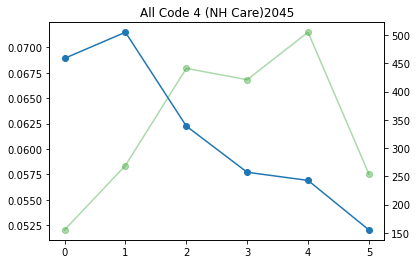

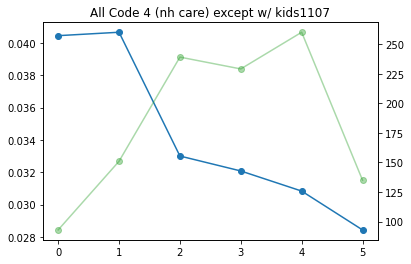

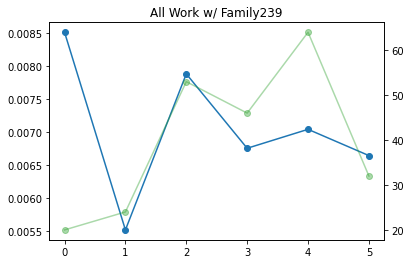

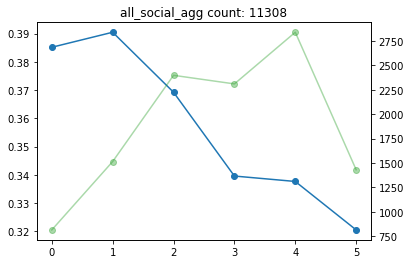

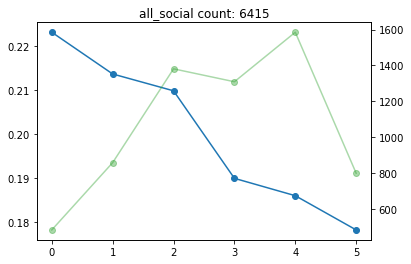

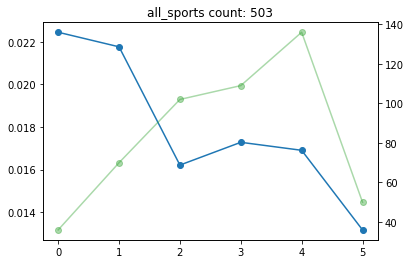

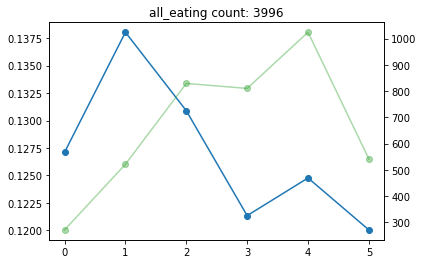

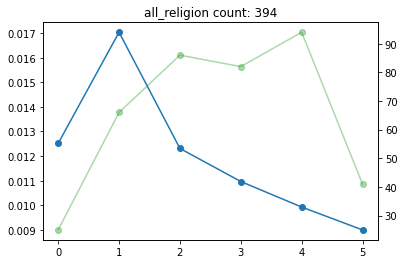

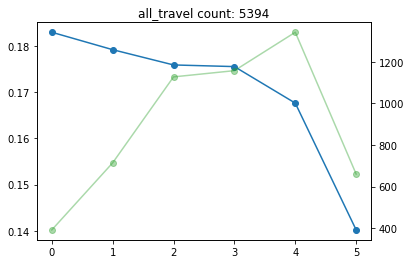

In [24]:

for col in binned_heaviside.columns.tolist()[-9:]:#[18:]:
    fig, ax = plt.subplots()
    ax.plot(binned_heaviside.index.tolist(),binned_heaviside[col])
    ax.scatter(binned_heaviside.index.tolist(),binned_heaviside[col])

    ax2 = ax.twinx()
    ax2.plot(binned_heaviside.index.tolist(), binned_counts[col],c='tab:green',alpha=0.4)
    ax2.scatter(binned_heaviside.index.tolist(), binned_counts[col],c='tab:green',alpha=0.4)
    count = binned_counts[col].sum()

    if col == '4_5':
        plt.title('Helping NH Adults '+str(count))
    elif col == 'all_4':
        plt.title('All Code 4 (NH Care)'+str(count))
    elif col == 'all_4_nokids':
        plt.title('All Code 4 (nh care) except w/ kids'+str(count))
    elif col == 'all_5':
        plt.title('All Work w/ Family'+str(count))
    else:
        plt.title(col+' count: '+str(count))
    plt.show()

In [25]:
def generate_tus_df(df_in,index='bin',weights='NEW_WEIGHT',target=['4_3','4_4','4_5'],keep_zero=False):
    df = copy.deepcopy(df_in)
    if not keep_zero:
        dfs = []
        counts = []
        for col in target:
            temp_df = copy.deepcopy(df)
            temp_df = temp_df[[index,weights,col]]
            temp_df = temp_df[temp_df[col]>0]
            temp_df_bin = temp_df.groupby(index).sum()
            temp_df_bin[col] = temp_df_bin[col]/temp_df_bin[weights]
            temp_df_count = temp_df.groupby(index).count()
            dfs.append(temp_df_bin)
            counts.append(temp_df_count)
        df_out = pd.concat(dfs,axis=1)
        df_count_out = pd.concat(counts,axis=1)
        df_out = df_out[[i for i in df_out.columns.tolist() if i!='NEW_WEIGHT']]
        df_count_out = df_count_out[[i for i in df_count_out.columns.tolist() if i!='NEW_WEIGHT']]
    else:
        df_out = df[[index,weights]+target].groupby(index).sum()
        df_count_out = df[[index,weights]+target].groupby(index).count()
        for col in target:
            df_out[col] = df_out[col] / df_out[weights]
        df_out = df_out[target]

    df_out = df_out.replace(np.nan,0)
    df_count_out = df_count_out.replace(np.nan,0)
    df_out = df_out.sort_index()
    df_count_out = df_count_out.sort_index()
    return df_out, df_count_out


In [26]:
def add_subplot(ax, x, y1, y2, title):
    ax.scatter(x,y1,color='tab:blue')
    ax.plot(x,y1,color='tab:blue')
    ax2 = ax.twinx()
    ax2.scatter(x,y2,color='tab:green',alpha=0.4)
    ax2.plot(x,y2,color='tab:green',alpha=0.4)
    ax.set_title(title)

In [32]:
# cols = df.columns.tolist()[6:]
# for i in range(len(cols)):
#     print(i,cols[i])

In [43]:
act_who_weighted.head()

TUCASEID GTCBSA  NEW_WEIGHT  bin         POP  LOG_POP  10_1  10_2  \
0  20160101160045  12060     20976.0  4.0   5862424.0     6.77     0     0   
1  20160101160069  47900     18319.0  4.0   6196585.0     6.79     0     0   
2  20160101160094  33100     57019.0  4.0   6090660.0     6.78     0     0   
3  20160101160116  35620     33681.0  5.0  19294236.0     7.29     0     0   
4  20160101160139  17140     18784.0  3.0   2201741.0     6.34     0     0   

   10_3  11_1  11_2    12_1  12_2  12_3  12_4  12_5  13_1  13_2  13_3  13_4  \
0     0     0     0  524400     0     0     0     0     0     0     0     0   
1     0     0     0       0     0     0     0     0     0     0     0     0   
2     0     0     0       0     0     0     0     0     0     0     0     0   
3     0     0     0       0     0     0     0     0     0     0     0     0   
4     0     0     0       0     0     0     0     0     0     0     0     0   

   13_99  14_1  14_99  15_1  15_2  15_3  15_4  15_5  15_7  15_8  15_99  16_1  \
0      0     0      0     0     0     0     0     0     0     0      0     0   
1      0     0      0     0     0     0     0     0     0     0      0     0   
2      0     0      0     0     0     0     0     0     0     0      0     0   
3      0     0      0     0     0     0     0     0     0     0      0     0   
4      0     0      0     0     0     0     0     0     0     0      0     0   

   16_2  18_1  18_10  18_11  18_12  18_13  18_14  18_15  18_16  18_18  18_2  \
0     0     0      0      0      0      0      0      0      0      0     0   
1     0     0      0      0      0      0      0      0      0      0     0   
2     0     0      0      0      0      0      0      0      0      0     0   
3     0     0      0      0      0      0      0      0      0      0     0   
4     0     0      0      0      0      0      0      0      0      0     0   

   18_3  18_4  18_5  18_6  18_7  18_8  18_9  18_99  1_3  1_5  2_1  2_2  2_3  \
0     0     0     0     0     0     0     0      0    0    0    0    0    0   
1     0     0     0     0     0     0     0      0    0    0    0    0    0   
2     0     0     0     0     0     0     0      0    0    0    0    0    0   
3     0     0     0     0     0     0     0      0    0    0    0    0    0   
4     0     0     0     0     0     0     0      0    0    0    0    0    0   

   2_4  2_5  2_6  2_7  2_8  2_9  2_99  3_1  3_2  3_3  3_4  3_5  4_1  4_2  4_3  \
0    0    0    0    0    0    0     0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0     0    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0     0    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0     0    0    0    0    0    0    0    0    0   
4    0    0    0    0    0    0     0    0    0    0    0    0    0    0    0   

   4_4  4_5  4_99  5_1  5_3  5_4  6_1  6_3  6_99  7_1  8_1  8_2  8_3  8_4  \
0    0    0     0    0    0    0    0    0     0    0    0    0    0    0   
1    0    0     0    0    0    0    0    0     0    0    0    0    0    0   
2    0    0     0    0    0    0    0    0     0    0    0    0    0    0   
3    0    0     0    0    0    0    0    0     0    0    0    0    0    0   
4    0    0     0    0    0    0    0    0     0    0    0    0    0    0   

   8_5  8_6  8_7  8_99  9_1  9_2  9_3  9_4  9_5  9_99  
0    0    0    0     0    0    0    0    0    0     0  
1    0    0    0     0    0    0    0    0    0     0  
2    0    0    0     0    0    0    0    0    0     0  
3    0    0    0     0    0    0    0    0    0     0  
4    0    0    0     0    0    0    0    0    0     0

In [34]:
act_who_weighted.to_csv('~/Documents/csi/csi-research/Data/atus_resp_who_agg.csv',index=False)

In [ ]:
df = copy.deepcopy(act_who_weighted)
cols = df.columns.tolist()[6:]
# df['11 - Eating and Drinking'] = df[cols[0:2]].sum(axis=1)
# df['12 - Relaxing, Socializing, Leisure'] = df[cols[3:7]].sum(axis=1)
# df['13 - Sports, Exercise, Recreation'] = df[cols[7:12]].sum(axis=1)
# df['14 - Religous and Spiritual Acitivity'] = df[cols[12:14]].sum(axis=1)
# df['4 - Caring for and Helping NH (ALL)'] = df[cols[14:20]].sum(axis=1)
# df['5 - Work & Work Related'] = df[cols[20:]].sum(axis=1)
# df['11-12 - Eating & Social'] = df[cols[0:7]].sum(axis=1)
df['4 - Caring for and Helping NH (Children)'] = df[cols[62:65]].sum(axis=1)
df['4 - Caring for and Helping NH (Adults)'] = df[cols[65:67]].sum(axis=1)
df['All except Travel'] = df[cols[:27]].sum(axis=1) + df[cols[45:]].sum(axis=1)
df['All including Travel'] = df[cols].sum(axis=1) 
df['11-12-13 - All Social'] = df[cols[3:17]].sum(axis=1)
df['All Care'] = df[cols[62:68]].sum(axis=1)
df['Only Travel'] = df[cols[27:45]].sum(axis=1)

df_heaviside = copy.deepcopy(df)
cols = df_heaviside.columns.tolist()[6:]
for col in cols:
    df_heaviside[col] = [1 if i>0 else 0 for i in df_heaviside[col].tolist()]
    df_heaviside[col] = df_heaviside[col] * df_heaviside['NEW_WEIGHT']

cols = df.columns.tolist()[6:]
df_o, df_c_o = generate_tus_df(df,target=cols,keep_zero=False)
df_h_o, df_h_c_o = generate_tus_df(df_heaviside, target=cols, keep_zero=True)
print(df_o.shape)
print(df_c_o.shape)
print(df_h_o.shape)

singles = cols[:-7]
combined = cols[-7:]
x_axis = df_o.index.tolist()



(6, 96)
(6, 96)
(6, 96)


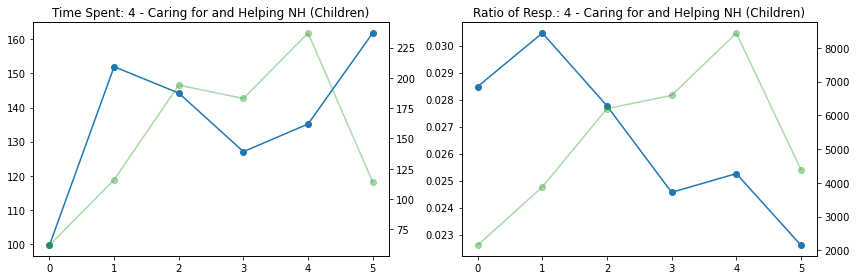

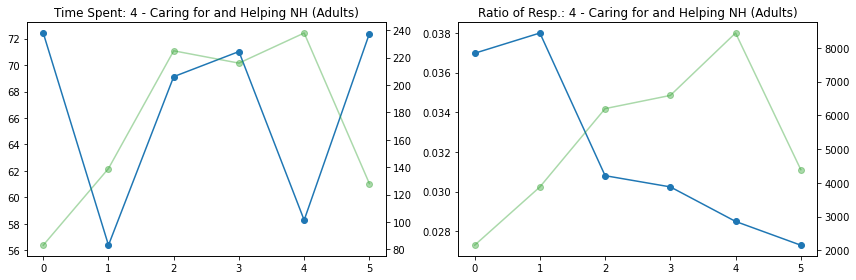

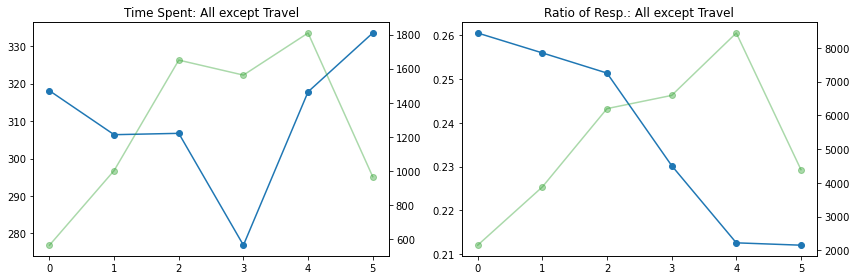

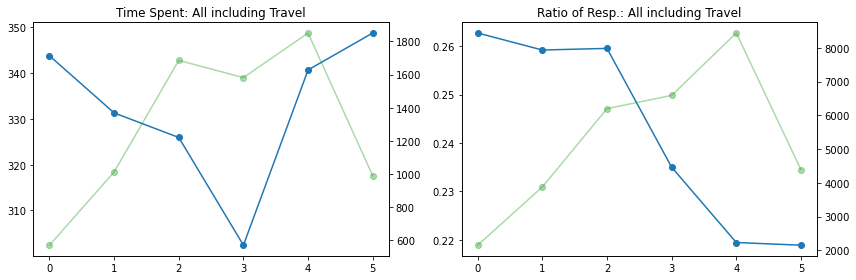

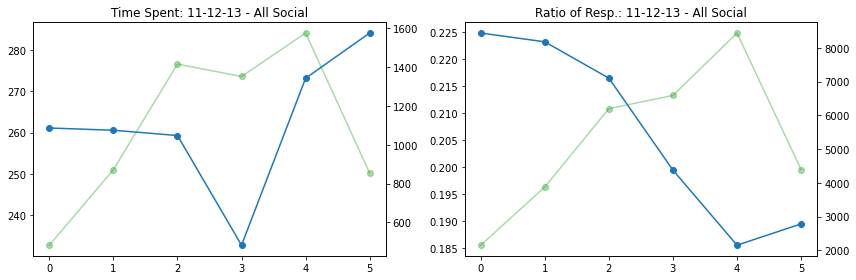

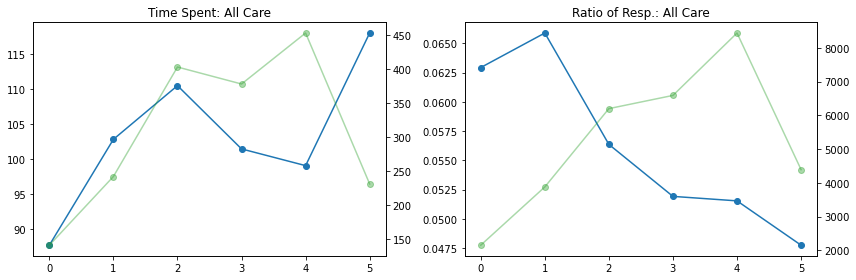

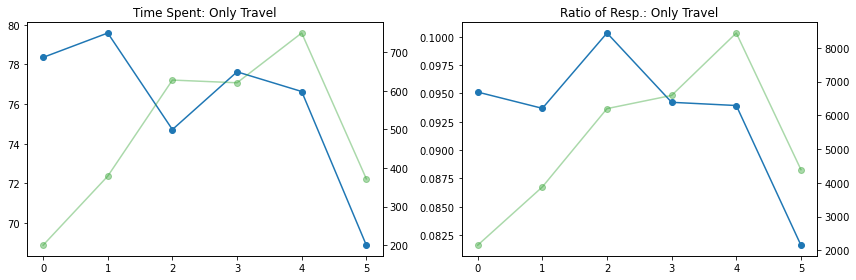

In [ ]:
for col in combined:
    fig, axs = plt.subplots(1,2,figsize = (12,4))
    add_subplot(axs[0],x_axis,df_o[col].tolist(), df_c_o[col].tolist(), 'Time Spent: '+col)
    add_subplot(axs[1],x_axis,df_h_o[col].tolist(), df_h_c_o[col].tolist(), 'Ratio of Resp.: '+col)
    plt.tight_layout()
    plt.savefig('/Users/jericho/Documents/csi/csi-research/plots/time_use/'+col+'.png')

In [ ]:
df_heaviside.head()

TUCASEID GTCBSA  NEW_WEIGHT  bin         POP  LOG_POP  10_1  10_2  \
0  20160101160045  12060     20976.0  4.0   5862424.0     6.77   0.0   0.0   
1  20160101160069  47900     18319.0  4.0   6196585.0     6.79   0.0   0.0   
2  20160101160094  33100     57019.0  4.0   6090660.0     6.78   0.0   0.0   
3  20160101160116  35620     33681.0  5.0  19294236.0     7.29   0.0   0.0   
4  20160101160139  17140     18784.0  3.0   2201741.0     6.34   0.0   0.0   

   10_3  11_1  11_2     12_1  12_2  12_3  12_4  12_5  13_1  13_2  13_3  13_4  \
0   0.0   0.0   0.0  20976.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   13_99  14_1  14_99  15_1  15_2  15_3  15_4  15_5  15_7  15_8  15_99  16_1  \
0    0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0   0.0   
1    0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0   0.0   
2    0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0   0.0   
3    0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0   0.0   
4    0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0   0.0   

   16_2  18_1  18_10  18_11  18_12  18_13  18_14  18_15  18_16  18_18  18_2  \
0   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   
1   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   
2   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   
3   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   
4   0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.0   

   18_3  18_4  18_5  18_6  18_7  18_8  18_9  18_99  1_3  1_5  2_1  2_2  2_3  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  0.0  0.0  0.0  0.0  0.0   

   2_4  2_5  2_6  2_7  2_8  2_9  2_99  3_1  3_2  3_3  3_4  3_5  4_1  4_2  4_3  \
0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   4_4  4_5  4_99  5_1  5_3  5_4  6_1  6_3  6_99  7_1  8_1  8_2  8_3  8_4  \
0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   

   8_5  8_6  8_7  8_99  9_1  9_2  9_3  9_4  9_5  9_99  \
0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0   
1  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0   
2  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0   
3  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0   
4  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0   

   4 - Caring for and Helping NH (Children)  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   4 - Caring for and Helping NH (Adults)  All excep

In [ ]:
counts = copy.deepcopy(df_heaviside)
counts = counts[counts.columns.tolist()[-6:]]
for col in counts.columns.tolist():
    count = sum([1 if i > 0 else 0 for i in counts[col].tolist()])
    print(col)
    print(count,'\n')

4 - Caring for and Helping NH (Children)
906 

4 - Caring for and Helping NH (Adults)
1029 

All except Travel
7553 

All including Travel
7693 

11-12-13 - All Social
6553 

All Care
1848 



In [ ]:
counts = copy.deepcopy(df_heaviside)
cols = counts.columns.tolist()
travel_cols = [i for i in cols if '18_' in i]

counts['just travel'] = counts[travel_cols].sum(axis=1)
counts = counts[counts.columns.tolist()[-7:]]
display(counts.head(3))
for col in counts.columns.tolist():
    count = sum([1 if i > 0 else 0 for i in counts[col].tolist()])
    t_count = sum([1 if i > 0 else 0 for i in counts['just travel'].tolist()])
    temp_df = counts[counts[col]>0]
    t_overlap_count = sum([1 if i > 0 else 0 for i in temp_df['just travel'].tolist()])
    print(col)
    #print(count,t_overlap_count, t_count-t_overlap_count, t_count,'\n')
    print(count-t_overlap_count, t_overlap_count, t_count-t_overlap_count,'\n')

4 - Caring for and Helping NH (Children)  \
0                                       0.0   
1                                       0.0   
2                                       0.0   

   4 - Caring for and Helping NH (Adults)  All except Travel  \
0                                     0.0            20976.0   
1                                     0.0                0.0   
2                                     0.0                0.0   

   All including Travel  11-12-13 - All Social  All Care  just travel  
0               20976.0                20976.0       0.0          0.0  
1                   0.0                    0.0       0.0          0.0  
2                   0.0                    0.0       0.0          0.0

4 - Caring for and Helping NH (Children)
358 548 2402 

4 - Caring for and Helping NH (Adults)
317 712 2238 

All except Travel
4743 2810 140 

All including Travel
4743 2950 0 

11-12-13 - All Social
4080 2473 477 

All Care
667 1181 1769 

just travel
0 2950 0 



In [ ]:
# # Single Metrics

# fig, axes = plt.subplots(8,3, figsize = (12,24))
# for i in range(len(singles)):
#     y,x = i%3, i//3    
#     add_subplot(axes[x,y],x_axis,df_o[singles[i]].tolist(), df_c_o[singles[i]].tolist(), singles[i])
# plt.tight_layout()
# plt.show()

# fig, axes = plt.subplots(18,4, figsize = (12,24))
# for i in range(len(singles)):
#     y,x = i%4, i//4    
#     add_subplot(axes[x,y],x_axis,df_h_o[singles[i]].tolist(), df_h_c_o[singles[i]].tolist(), singles[i])
# plt.tight_layout()
# plt.show()


# # Combined Metrics

# fig, axes = plt.subplots(6,2, figsize = (10,15))
# for i in range(len(combined)):
#     y,x = i%2, i//2    
#     add_subplot(axes[x,y],x_axis,df_o[combined[i]].tolist(), df_c_o[combined[i]].tolist(), combined[i])
# plt.tight_layout()
# plt.show()

# fig, axes = plt.subplots(6,2, figsize = (10,15))
# for i in range(len(combined)):
#     y,x = i%2, i//2    
#     add_subplot(axes[x,y],x_axis,df_h_o[combined[i]].tolist(), df_h_c_o[combined[i]].tolist(), combined[i])
# plt.tight_layout()
# plt.show()

In [ ]:
%pwd

'/Users/jericho/Documents/csi/csi-research/Notebooks'

In [ ]:
df = copy.deepcopy(act_who_weighted)
cols = df.columns.tolist()[6:]
# df['11 - Eating and Drinking'] = df[cols[0:2]].sum(axis=1)
# df['12 - Relaxing, Socializing, Leisure'] = df[cols[3:7]].sum(axis=1)
# df['13 - Sports, Exercise, Recreation'] = df[cols[7:12]].sum(axis=1)
# df['14 - Religous and Spiritual Acitivity'] = df[cols[12:14]].sum(axis=1)
# df['4 - Caring for and Helping NH (ALL)'] = df[cols[14:20]].sum(axis=1)
# df['5 - Work & Work Related'] = df[cols[20:]].sum(axis=1)
# df['11-12 - Eating & Social'] = df[cols[0:7]].sum(axis=1)
df['4 - Caring for and Helping NH (Children)'] = df[cols[62:65]].sum(axis=1)
df['4 - Caring for and Helping NH (Adults)'] = df[cols[65:67]].sum(axis=1)
df['All except Travel'] = df[cols[:27]].sum(axis=1) + df[cols[45:]].sum(axis=1)
df['All including Travel'] = df[cols].sum(axis=1) 
df['11-12-13 - All Social'] = df[cols[3:17]].sum(axis=1)
df['All Care'] = df[cols[62:68]].sum(axis=1)
df['Only Travel'] = df[cols[27:45]].sum(axis=1)

df = df[df['Only Travel'] == 0]

df_heaviside = copy.deepcopy(df)
cols = df_heaviside.columns.tolist()[6:]
for col in cols:
    df_heaviside[col] = [1 if i>0 else 0 for i in df_heaviside[col].tolist()]
    df_heaviside[col] = df_heaviside[col] * df_heaviside['NEW_WEIGHT']

cols = df.columns.tolist()[6:]
df_o, df_c_o = generate_tus_df(df,target=cols,keep_zero=False)
df_h_o, df_h_c_o = generate_tus_df(df_heaviside, target=cols, keep_zero=True)
print(df_o.shape)
print(df_c_o.shape)
print(df_h_o.shape)

singles = cols[:-7]
combined = cols[-7:]
x_axis = df_o.index.tolist()

(6, 96)
(6, 96)
(6, 96)


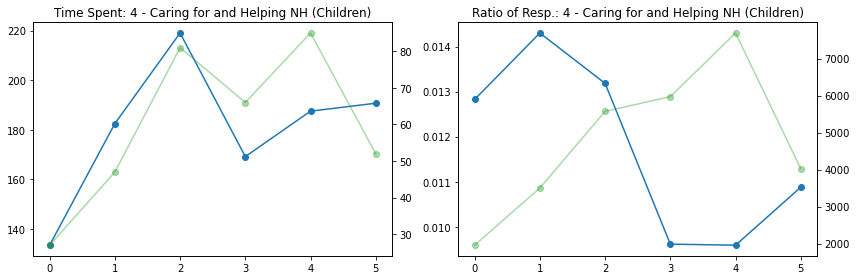

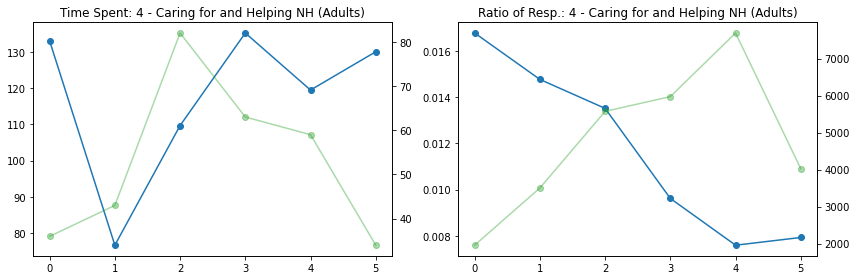

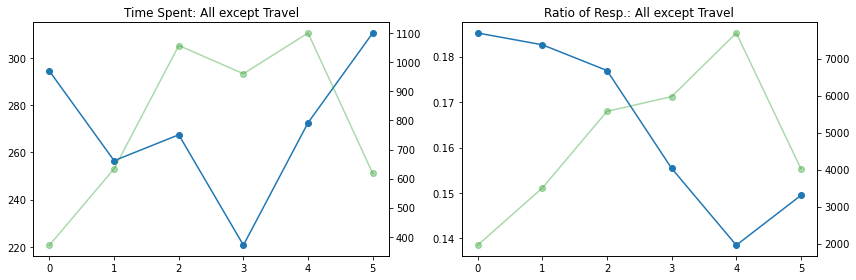

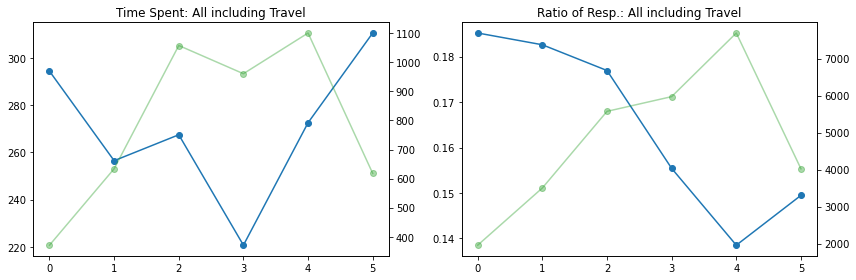

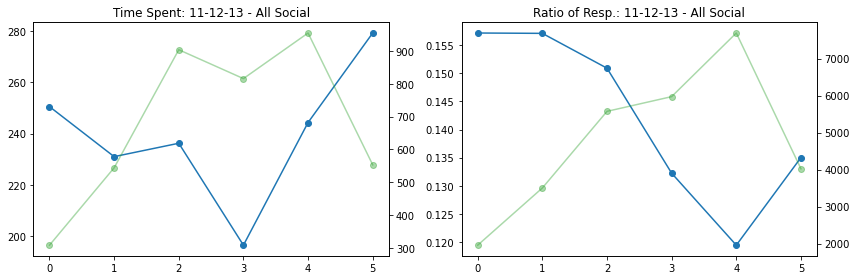

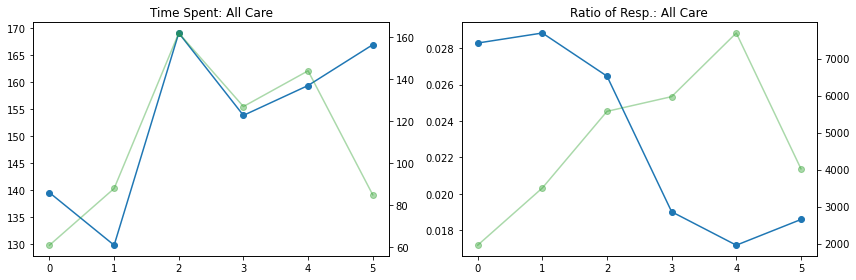

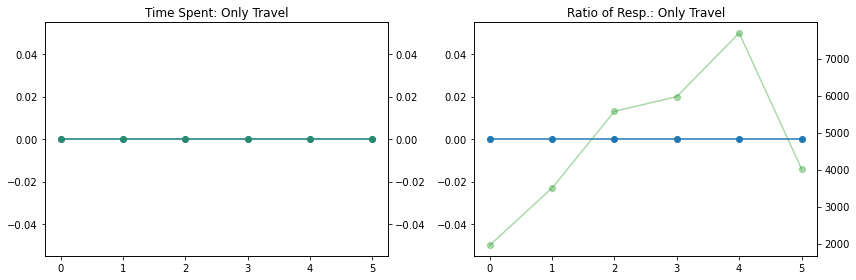

In [ ]:
for col in combined:
    fig, axs = plt.subplots(1,2,figsize = (12,4))
    add_subplot(axs[0],x_axis,df_o[col].tolist(), df_c_o[col].tolist(), 'Time Spent: '+col)
    add_subplot(axs[1],x_axis,df_h_o[col].tolist(), df_h_c_o[col].tolist(), 'Ratio of Resp.: '+col)
    plt.tight_layout()
    plt.savefig('/Users/jericho/Documents/csi/csi-research/plots/time_use/'+col+'.png')